# Sentiment Analysis with Stanford Treebank

1.  Find a sentiment dataset, to train a generic sentiment model. --> (any dataset) but chaky recommend https://nlp.stanford.edu/sentiment/treebank.html
2.  Test your model, such that it SHOULD pass negative negative sentence (2), and negative positive sentence (2)
3.  Create a website:
     1.  Input one thing:  "Mac mini 2022", or "Surface book", "#bitcoin", "Chaklam NLP class"
     2.  Scrap twitter data related to these products (no need too many posts....just like 50 posts...)
     3.  Plot the graph, how many posts are positive and negative
     4.  What are top words / entities inside positive comments, and negative comments

# 1. Load Dataset

In [3]:
import pytreebank
import torch, torchdata, torchtext
from torch import nn
import time

c:\Users\Sirikit Joshi\.conda\envs\cudaenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
dataset = pytreebank.load_sst("./sentiment/")

In [7]:
train_data = pytreebank.import_tree_corpus("./sentiment/train.txt")
test_data = pytreebank.import_tree_corpus("./sentiment/test.txt")
dev_data = pytreebank.import_tree_corpus("./sentiment/dev.txt")

In [8]:
td = train_data[0]
for label, sentence in td.to_labeled_lines():
  print(label, sentence)
  break

3 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .


In [9]:
set([label for t in train_data for label, sentence in t.to_labeled_lines()])

{0, 1, 2, 3, 4}

In [10]:
def flatten(data):
   return  [(label, text) for d in data for label,text in d.to_labeled_lines()]

In [11]:
train_data = flatten(train_data)
test_data = flatten(test_data)
valid_data = flatten(dev_data)

In [12]:
for td in train_data:
  if td[0] == -1:
    print(td[0])
    break

In [13]:
train_size = len(train_data)
test_size = len(test_data)
valid_size = len(valid_data)

In [14]:
train_size, test_size, valid_size

(318582, 82600, 41447)

# 2. Preprocessing
## 2.1 Tokenization

In [15]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [16]:
tokens = tokenizer(train_data[0][1])
tokens

['The',
 'Rock',
 'is',
 'destined',
 'to',
 'be',
 'the',
 '21st',
 'Century',
 "'s",
 'new',
 '`',
 '`',
 'Conan',
 "''",
 'and',
 'that',
 'he',
 "'s",
 'going',
 'to',
 'make',
 'a',
 'splash',
 'even',
 'greater',
 'than',
 'Arnold',
 'Schwarzenegger',
 ',',
 'Jean',
 '-',
 'Claud',
 'Van',
 'Damme',
 'or',
 'Steven',
 'Segal',
 '.']

### 2.2 Numericalization

In [17]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  #data_iter, e.g., train
    for _, text in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

In [18]:
vocab.set_default_index(vocab["<unk>"]) 

In [19]:
vocab(tokens)

[24,
 1131,
 13,
 6308,
 9,
 28,
 4,
 2595,
 2551,
 12,
 134,
 25,
 25,
 5994,
 69,
 8,
 15,
 93,
 12,
 243,
 9,
 89,
 6,
 5953,
 84,
 3652,
 40,
 2304,
 2511,
 5,
 3175,
 11,
 7357,
 2562,
 4927,
 43,
 896,
 8149,
 10]

In [20]:
id2word = vocab.get_itos()

In [21]:
id2word[0]

'<unk>'

In [22]:
vocab(['<pad>','<bos>','<eos>'])

[1, 2, 3]

In [23]:
len(vocab)

17136

# 3. FastText Embedding

In [24]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

.vector_cache\wiki.simple.vec: 293MB [00:23, 12.7MB/s]                               
100%|██████████| 111051/111051 [00:10<00:00, 11009.99it/s]


In [25]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [26]:
fast_embedding.shape

torch.Size([17136, 300])

In [27]:
fast_embedding[100][:10]

tensor([-0.0595, -0.0829,  0.0264, -0.2511, -0.0340,  0.2841,  0.1026, -0.0634,
         0.0880,  0.1869], device='cuda:0')

# 4. Preparing dataloader

In [28]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence 

In [29]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x:int(x)

In [30]:
pad_idx = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_idx, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [31]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)

In [32]:
train_loader_length = len(list(iter(train_loader)))
valid_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [33]:
train_loader_length,valid_loader_length,test_loader_length

(4978, 648, 1291)

In [34]:
for label, text, length in train_loader:
  break

In [35]:
label, text, length

(tensor([2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1,
         3, 2, 3, 2, 3, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
         2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4, 3, 2]),
 tensor([[  273,     1,     1,  ...,     1,     1,     1],
         [12727,   238,   278,  ...,     1,     1,     1],
         [ 1045,   175,     1,  ...,     1,     1,     1],
         ...,
         [  365,    65,     1,  ...,     1,     1,     1],
         [   13,  2479,     9,  ...,     1,     1,     1],
         [   24,    18,     1,  ...,     1,     1,     1]]),
 tensor([ 1,  3,  2,  1,  1,  5,  6,  1, 16, 15,  1,  1,  1, 16,  3,  1,  1,  4,
          5,  2,  1,  1,  1,  1,  1,  1,  4,  2,  8,  2,  1,  8,  1,  1,  1,  1,
         13, 12,  1,  2,  1,  7,  1,  1,  1,  4,  3,  1,  1,  8,  1,  4,  2,  8,
          1,  1,  6,  7,  2,  1,  6,  2,  4,  2]))

In [36]:
label.shape, text.shape, length.shape

(torch.Size([64]), torch.Size([64, 16]), torch.Size([64]))

# 5. Designing the model

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-1,:,:], hn[-2,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

# 6. Training

In [38]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [39]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300         #**<----change to 300
output_dim = 5 #five classes

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embeddi

In [40]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

5140800
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2560
     5
______
7863109


In [41]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [42]:
def accuracy(preds, y):
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [43]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader):
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)

        if i%500 == 0:
          print(f"Training {i} out of {loader_length}") 
        
        #predict
        predictions = model(text, text_length).squeeze(1)
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [44]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)
            
            predictions = model(text, text_length).squeeze(1) 
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
best_valid_loss = float('inf')
num_epochs      = 10
tolerance_counter = 0

save_path = f'models/{model.__class__.__name__}_TreeBank.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    print(f"Start epoch {epoch}")
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, valid_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        tolerance_counter = 0
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f"End epoch {epoch}")
    # Tolerance techniques, stop the model if it start to overfit.
    if tolerance_counter >= 3:
        break

    tolerance_counter = tolerance_counter + 1

Start epoch 0
Training 0 out of 4978
Training 500 out of 4978
Training 1000 out of 4978
Training 1500 out of 4978
Training 2000 out of 4978
Training 2500 out of 4978
Training 3000 out of 4978
Training 3500 out of 4978
Training 4000 out of 4978
Training 4500 out of 4978
Epoch: 01 | Time: 1m 17s
	Train Loss: 0.354 | Train Acc: 85.27%
	 Val. Loss: 0.449 |  Val. Acc: 82.13%
End epoch 0
Start epoch 1
Training 0 out of 4978
Training 500 out of 4978
Training 1000 out of 4978
Training 1500 out of 4978
Training 2000 out of 4978
Training 2500 out of 4978
Training 3000 out of 4978
Training 3500 out of 4978
Training 4000 out of 4978
Training 4500 out of 4978
Epoch: 02 | Time: 1m 38s
	Train Loss: 0.313 | Train Acc: 86.91%
	 Val. Loss: 0.481 |  Val. Acc: 79.98%
End epoch 1
Start epoch 2
Training 0 out of 4978
Training 500 out of 4978
Training 1000 out of 4978
Training 1500 out of 4978
Training 2000 out of 4978
Training 2500 out of 4978
Training 3000 out of 4978
Training 3500 out of 4978
Training 400

Text(0, 0.5, 'loss')

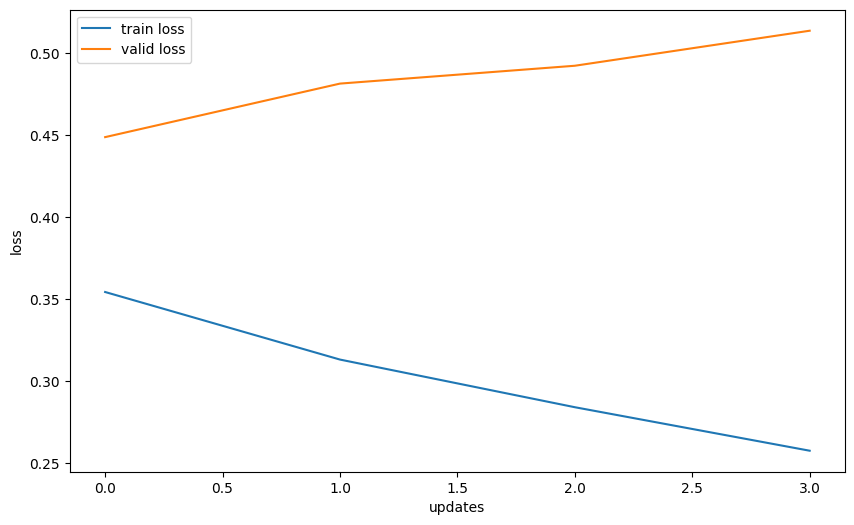

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

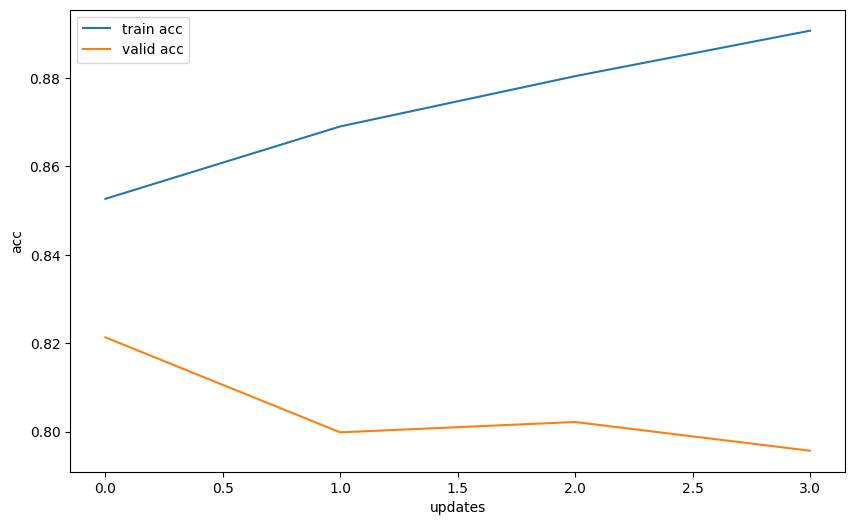

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [50]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.456 | Test Acc: 81.86%


# 7. Testing on some random news

In [62]:
test_str_list = [
    'What a waste of space, why is this trash even here',
    'The movie was not as good as I expected',
    'Overall, the movie was not the worst',
    'This movie was terribly fantastic',
    "WOW, this is the best movie of all time" 
    ] 

In [52]:
def prediction(test_str_list):
    result = list()
    for test_str in test_str_list:
        text = torch.tensor(text_pipeline(test_str)).to(device).reshape(1, -1)
        # text_list = [x.item() for x in text]
        text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1] #.detach().cpu().numpy()
        result.append((test_str, predicted.item()))
    return result

In [63]:
prediction(test_str_list)

[('What a waste of space, why is this trash even here', 0),
 ('The movie was not as good as I expected', 1),
 ('Overall, the movie was not the worst', 2),
 ('This movie was terribly fantastic', 3),
 ('WOW, this is the best movie of all time', 4)]